In [1]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Dataset import Dataset
from Setting import Setting

torch.cuda.is_available()

False

# General settings

In [2]:
# Set the random seed for reproducibility.
random_seed = 1
#tf.random.set_random_seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

args = Setting()
device = args.device
dataset = Dataset(args.dataset_path, args.batch_size, args.fast_testing)

# Preprocess dataframe

In [3]:
dataframe = dataset.data_full.drop_duplicates(subset=['UserID', 'MovieID', 'Timestamp'])
dataframe

,UserID,MovieID,CategoryID,Rating,Timestamp
474,101,177,4,4,874724710
178269,101,289,7,4,874724727
90841,101,153,0,4,874724754
45079,101,361,10,4,874724781
175466,101,321,0,4,874724843
...,...,...,...,...,...
98754,724,890,0,4,893286638
157460,724,652,0,4,893286638
98345,724,98,0,3,893286638
168106,724,130,7,4,893286638


In [4]:
# Converts timestamp in a DateTime object.
dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], unit='s')
dataframe = dataframe.sort_values(by='Timestamp')
dataframe['Month'] = dataframe['Timestamp'].dt.to_period('M')
dataframe

,UserID,MovieID,CategoryID,Rating,Timestamp,Month
474,101,177,4,4,1997-09-20 03:05:10,1997-09
178269,101,289,7,4,1997-09-20 03:05:27,1997-09
90841,101,153,0,4,1997-09-20 03:05:54,1997-09
45079,101,361,10,4,1997-09-20 03:06:21,1997-09
175466,101,321,0,4,1997-09-20 03:07:23,1997-09
...,...,...,...,...,...,...
98754,724,890,0,4,1998-04-22 23:10:38,1998-04
157460,724,652,0,4,1998-04-22 23:10:38,1998-04
98345,724,98,0,3,1998-04-22 23:10:38,1998-04
168106,724,130,7,4,1998-04-22 23:10:38,1998-04


In [5]:
distribution_per_month = dataframe['Month'].value_counts().sort_index()
distribution_per_month

1997-09     6704
1997-10    10304
1997-11    23980
1997-12    11911
1998-01    14095
1998-02    10991
1998-03    12656
1998-04     9359
Freq: M, Name: Month, dtype: int64

# Preference change from first month

In [6]:
def get_user_distribution(user_dataframe, user_items):
    
    user_movies_data = dataset.movies_data[dataset.movies_data['MovieID'].isin(user_items)]
    
    # We merge the relevant items with their categories. Then we drop useless attributes.
    merged_df = pd.merge(user_dataframe, user_movies_data, on='MovieID', how='inner')
    merged_df  = merged_df.drop('Timestamp', axis=1) 
    merged_df  = merged_df.drop('UserID', axis=1)
    merged_df  = merged_df.drop('CategoryID', axis=1)
    
    # We assign the rating of the item to each of its categories. 
    for i in range(dataset.n_categories):
        category_col = f'Category_{i}'
        rating_col = 'Rating'
        merged_df[category_col] *= merged_df[rating_col]
    merged_df = merged_df.drop('Rating', axis=1)
    merged_df = merged_df.drop_duplicates()
    
    # We compute the mean value for each category. This is the user profile.
    categories = [f'Category_{i}' for i in range(dataset.n_categories)]
    category_values = []
    for category in categories:
        # We compute the mean only for the values that are not 0,
        # since we consider 0 as an absence of value.
        values = merged_df[category].values
        values = values[values != 0]
        if len(values) > 0:
            values = np.mean(values)
            values = round(values)
        else:
            values = 0
        category_values.append(values)
        
    if all(value == 0 for value in category_values):
        active_user = False
    else:
        active_user = True

    user_distribution = torch.nn.functional.softmax(torch.FloatTensor(category_values), dim=0)
    
    return user_distribution, active_user

In [7]:
first_month = "1997-09"
second_month = "1997-10"
third_month = "1997-11"
fourth_month = "1997-12"
fifth_month = "1998-01"
sixth_month = "1998-02"
seventh_month = "1998-03"
eighth_month = "1998-04"
months_list = [first_month, second_month, third_month, fourth_month, fifth_month,
               sixth_month, seventh_month, eighth_month]
dataframe['Month'] = dataframe['Month'].astype(str)

In [8]:
months_list_time_slot = []
months_list_time_slot.append(months_list[0])
months_list_time_slot.append(months_list[0])
months_list_time_slot

['1997-09', '1997-09']

In [9]:
total_distributions = []
total_active_users = []
for i in range(8):
    months_list_time_slot = []
    if i == 0:
        months_list_time_slot.append(months_list[i])
    else:
        months_list_time_slot.append(months_list[i-1])
        months_list_time_slot.append(months_list[i])
    dataframe_slot = dataframe[dataframe['Month'].isin(months_list_time_slot)]
    dataframe_slot = dataframe_slot.sort_values(by='Timestamp')
    
    slot_distributions = []
    slot_active_users = []
    for user_id in range(dataset.n_users):
        user_dataframe = dataframe_slot[dataframe_slot['UserID'] == user_id]
        user_items = user_dataframe['MovieID'].values
        user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
        slot_distributions.append(user_distribution)
        if active_user:
            slot_active_users.append(user_id)
    slot_distributions = torch.vstack(slot_distributions)
    
    total_distributions.append(slot_distributions)
    total_active_users.append(slot_active_users)

In [10]:
print(len(total_distributions))
print(total_distributions)
print(len(total_active_users))
print(total_active_users)

8
[tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        ...,
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]]), tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        ...,
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0517, 0.0517, 0.1406,  ..., 0.0517, 0.1406, 0.0009]]), tensor([[0.0556, 0.0556, 0.0556,  ..., 0.0556, 0.0556, 0.0556],
        [0.0355, 0.0355, 0.0965,  ..., 0.0965, 0.0355, 0.2622],
        [0.0733, 0.0270, 0.0013,  ..., 0.0733, 0.0733, 0.0733],
       

In [11]:
total_variations = []
for i in range(8):
    if i != 0:
        first_slot_active_users = total_active_users[0]
        second_slot_active_users = total_active_users[i]
        first_slot_distributions = total_distributions[0]
        second_slot_distributions = total_distributions[i]
        common_users_two_slots = list(set(first_slot_active_users) & set(second_slot_active_users))
        filtered_first_slot_distributions = first_slot_distributions[common_users_two_slots]
        filtered_second_slot_distributions = second_slot_distributions[common_users_two_slots]
        variation_distance = torch.nn.functional.kl_div(input=filtered_second_slot_distributions, target=filtered_first_slot_distributions, reduction='none')
        variation_distance = torch.mean(variation_distance, dim=0)
        total_variations.append(variation_distance)

In [12]:
print(len(total_variations))
print(total_variations)

7
[tensor([-0.1816, -0.1686, -0.1492, -0.1423, -0.1635, -0.1691, -0.0714, -0.1927,
        -0.0737, -0.1099, -0.1191, -0.1128, -0.1575, -0.1681, -0.1656, -0.1781,
        -0.1915, -0.0883]), tensor([-0.1856, -0.1650, -0.1343, -0.1291, -0.1498, -0.1597, -0.0648, -0.1979,
        -0.0722, -0.1265, -0.1123, -0.1220, -0.1400, -0.1664, -0.1624, -0.1840,
        -0.1943, -0.1026]), tensor([-0.1911, -0.1620, -0.1340, -0.1171, -0.1607, -0.1429, -0.0630, -0.1970,
        -0.0643, -0.1191, -0.1123, -0.0982, -0.1305, -0.1572, -0.1584, -0.1823,
        -0.1938, -0.1091]), tensor([-0.1817, -0.1617, -0.1332, -0.1271, -0.1603, -0.1576, -0.0806, -0.1943,
        -0.0715, -0.1182, -0.1059, -0.1107, -0.1238, -0.1643, -0.1590, -0.1770,
        -0.1981, -0.1068]), tensor([-0.1758, -0.1614, -0.1387, -0.1307, -0.1533, -0.1749, -0.0762, -0.2002,
        -0.0701, -0.1162, -0.1192, -0.1161, -0.1359, -0.1706, -0.1609, -0.1749,
        -0.1977, -0.0993]), tensor([-0.1738, -0.1510, -0.1432, -0.1199, -0.1636, -0.1

## Plot

In [13]:
for i in range(7):
    series = pd.Series(total_variations[i])
    if i == 0:
        df = pd.DataFrame(series)
    else:
        df = pd.concat([df, series], axis=1)
df

,0,0,0,0,0,0,0
0,-0.181632,-0.185635,-0.191144,-0.181686,-0.175799,-0.173817,-0.174263
1,-0.168573,-0.165048,-0.162035,-0.161733,-0.161426,-0.151022,-0.150075
2,-0.149177,-0.134345,-0.133988,-0.133222,-0.138711,-0.143174,-0.136315
3,-0.142342,-0.129086,-0.117123,-0.127097,-0.130653,-0.119886,-0.122141
4,-0.163549,-0.149838,-0.160741,-0.160257,-0.153308,-0.163591,-0.162572
5,-0.169084,-0.159748,-0.142911,-0.157599,-0.174866,-0.176996,-0.158701
6,-0.071388,-0.064839,-0.063035,-0.080599,-0.076237,-0.071766,-0.071824
7,-0.192689,-0.197947,-0.197022,-0.194313,-0.200236,-0.209668,-0.218432
8,-0.073720,-0.072177,-0.064250,-0.071504,-0.070078,-0.064890,-0.075395
9,-0.109914,-0.126522,-0.119054,-0.118171,-0.116215,-0.120821,-0.122644


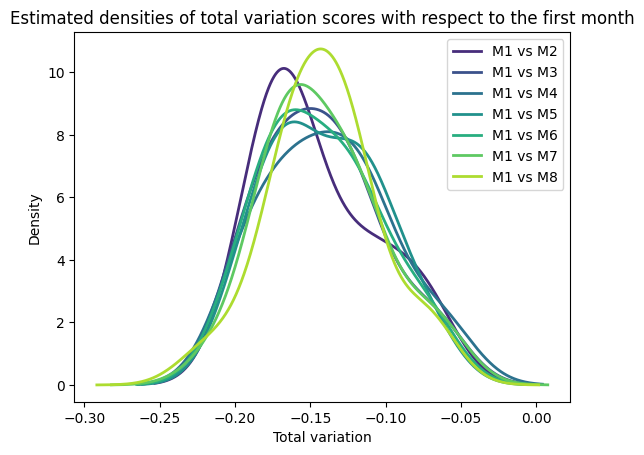

In [14]:
colors = sns.color_palette("viridis", n_colors=len(df.columns))
ax = df.plot.kde(color=colors, linewidth=2)
plt.title('Estimated densities of total variation scores with respect to the first month')
plt.xlabel('Total variation')
plt.ylabel('Density')
labels = ['M1 vs M2', 'M1 vs M3', 'M1 vs M4', 'M1 vs M5', 'M1 vs M6', 'M1 vs M7', 'M1 vs M8']
plt.legend(labels)
plt.show()

# Preference change from previous month

In [15]:
total_variations = []
for i in range(8):
    if i != 0:
        first_slot_active_users = total_active_users[i-1]
        second_slot_active_users = total_active_users[i]
        first_slot_distributions = total_distributions[i-1]
        second_slot_distributions = total_distributions[i]
        common_users_two_slots = list(set(first_slot_active_users) & set(second_slot_active_users))
        filtered_first_slot_distributions = first_slot_distributions[common_users_two_slots]
        filtered_second_slot_distributions = second_slot_distributions[common_users_two_slots]
        variation_distance = torch.nn.functional.kl_div(input=filtered_second_slot_distributions, target=filtered_first_slot_distributions, reduction='none')
        variation_distance = torch.mean(variation_distance, dim=0)
        total_variations.append(variation_distance)

In [16]:
print(len(total_variations))
print(total_variations)

7
[tensor([-0.1816, -0.1686, -0.1492, -0.1423, -0.1635, -0.1691, -0.0714, -0.1927,
        -0.0737, -0.1099, -0.1191, -0.1128, -0.1575, -0.1681, -0.1656, -0.1781,
        -0.1915, -0.0883]), tensor([-0.1707, -0.1642, -0.1276, -0.1331, -0.1549, -0.1772, -0.0824, -0.1902,
        -0.0791, -0.1131, -0.1184, -0.1366, -0.1612, -0.1789, -0.1652, -0.1715,
        -0.2040, -0.0959]), tensor([-0.1595, -0.1619, -0.1228, -0.1309, -0.1582, -0.1828, -0.0830, -0.1936,
        -0.0860, -0.1211, -0.1262, -0.1358, -0.1751, -0.1820, -0.1637, -0.1683,
        -0.1958, -0.1019]), tensor([-0.1640, -0.1530, -0.1260, -0.1360, -0.1581, -0.1823, -0.0675, -0.1940,
        -0.0758, -0.1174, -0.1248, -0.1343, -0.1773, -0.1815, -0.1661, -0.1706,
        -0.1852, -0.0984]), tensor([-0.1828, -0.1532, -0.1145, -0.1259, -0.1608, -0.1681, -0.0643, -0.2059,
        -0.0796, -0.1216, -0.1203, -0.1150, -0.1506, -0.1950, -0.1656, -0.1750,
        -0.1755, -0.0866]), tensor([-0.1875, -0.1413, -0.0948, -0.1067, -0.1678, -0.1

## Plot

In [17]:
for i in range(7):
    series = pd.Series(total_variations[i])
    if i == 0:
        df = pd.DataFrame(series)
    else:
        df = pd.concat([df, series], axis=1)
df

,0,0,0,0,0,0,0
0,-0.181632,-0.170686,-0.159484,-0.163976,-0.182789,-0.187484,-0.170824
1,-0.168573,-0.164180,-0.161925,-0.153010,-0.153154,-0.141296,-0.150778
2,-0.149177,-0.127555,-0.122821,-0.126034,-0.114504,-0.094802,-0.090386
3,-0.142342,-0.133095,-0.130928,-0.136026,-0.125926,-0.106652,-0.114029
4,-0.163549,-0.154877,-0.158199,-0.158102,-0.160793,-0.167821,-0.181757
5,-0.169084,-0.177186,-0.182816,-0.182339,-0.168137,-0.168535,-0.173615
6,-0.071388,-0.082392,-0.082976,-0.067532,-0.064300,-0.068639,-0.063718
7,-0.192689,-0.190176,-0.193573,-0.193993,-0.205858,-0.216327,-0.213194
8,-0.073720,-0.079056,-0.086013,-0.075831,-0.079613,-0.070599,-0.066853
9,-0.109914,-0.113107,-0.121052,-0.117388,-0.121555,-0.106295,-0.126364


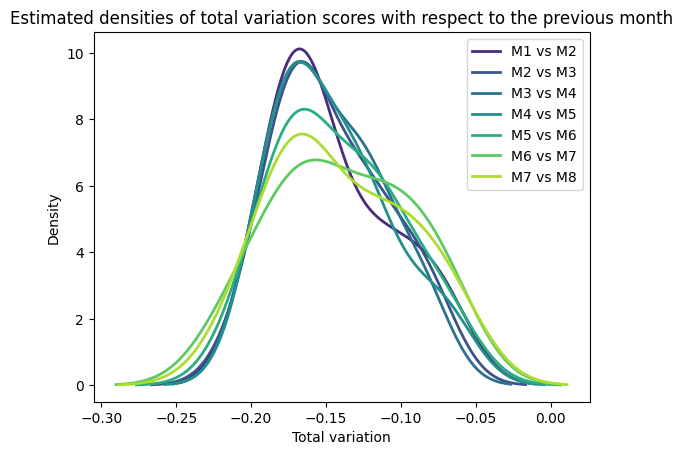

In [18]:
colors = sns.color_palette("viridis", n_colors=len(df.columns))
ax = df.plot.kde(color=colors, linewidth=2)
plt.title('Estimated densities of total variation scores with respect to the previous month')
plt.xlabel('Total variation')
plt.ylabel('Density')
labels = ['M1 vs M2', 'M2 vs M3', 'M3 vs M4', 'M4 vs M5', 'M5 vs M6', 'M6 vs M7', 'M7 vs M8']
plt.legend(labels)
plt.show()

# Preference change from previous month with full history

In [19]:
total_distributions = []
total_active_users = []
for i in range(8):
    months_list_time_slot = []
    months_list_time_slot.append(months_list[0])
    months_list_time_slot.append(months_list[i])
    dataframe_slot = dataframe[dataframe['Month'].isin(months_list_time_slot)]
    dataframe_slot = dataframe_slot.sort_values(by='Timestamp')
    
    slot_distributions = []
    slot_active_users = []
    for user_id in range(dataset.n_users):
        user_dataframe = dataframe_slot[dataframe_slot['UserID'] == user_id]
        user_items = user_dataframe['MovieID'].values
        user_distribution, active_user = get_user_distribution(user_dataframe, user_items)
        slot_distributions.append(user_distribution)
        if active_user:
            slot_active_users.append(user_id)
    slot_distributions = torch.vstack(slot_distributions)
    
    total_distributions.append(slot_distributions)
    total_active_users.append(slot_active_users)

In [20]:
total_variations = []
for i in range(8):
    if i != 0:
        first_slot_active_users = total_active_users[i-1]
        second_slot_active_users = total_active_users[i]
        first_slot_distributions = total_distributions[i-1]
        second_slot_distributions = total_distributions[i]
        common_users_two_slots = list(set(first_slot_active_users) & set(second_slot_active_users))
        filtered_first_slot_distributions = first_slot_distributions[common_users_two_slots]
        filtered_second_slot_distributions = second_slot_distributions[common_users_two_slots]
        variation_distance = torch.nn.functional.kl_div(input=filtered_second_slot_distributions, target=filtered_first_slot_distributions, reduction='none')
        variation_distance = torch.mean(variation_distance, dim=0)
        total_variations.append(variation_distance)

## Plot

In [21]:
for i in range(7):
    series = pd.Series(total_variations[i])
    if i == 0:
        df = pd.DataFrame(series)
    else:
        df = pd.concat([df, series], axis=1)
df

,0,0,0,0,0,0,0
0,-0.181632,-0.171015,-0.161337,-0.176886,-0.187794,-0.180764,-0.180598
1,-0.168573,-0.155238,-0.165271,-0.155677,-0.147656,-0.147999,-0.152823
2,-0.149177,-0.144982,-0.140187,-0.131878,-0.128765,-0.122921,-0.124197
3,-0.142342,-0.143637,-0.135257,-0.135119,-0.123313,-0.120077,-0.124474
4,-0.163549,-0.161793,-0.156629,-0.174096,-0.169064,-0.180103,-0.173121
5,-0.169084,-0.171273,-0.180383,-0.166080,-0.167166,-0.157055,-0.162498
6,-0.071388,-0.077869,-0.077708,-0.063061,-0.071682,-0.066099,-0.070306
7,-0.192689,-0.190451,-0.194585,-0.199620,-0.202561,-0.208769,-0.203852
8,-0.073720,-0.080623,-0.086716,-0.073277,-0.072221,-0.069137,-0.068067
9,-0.109914,-0.109901,-0.114773,-0.095910,-0.099607,-0.101616,-0.104328


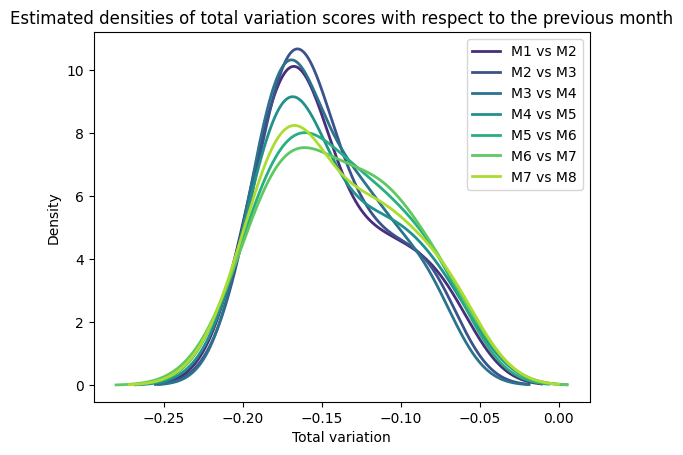

In [22]:
colors = sns.color_palette("viridis", n_colors=len(df.columns))
ax = df.plot.kde(color=colors, linewidth=2)
plt.title('Estimated densities of total variation scores with respect to the previous month')
plt.xlabel('Total variation')
plt.ylabel('Density')
labels = ['M1 vs M2', 'M2 vs M3', 'M3 vs M4', 'M4 vs M5', 'M5 vs M6', 'M6 vs M7', 'M7 vs M8']
plt.legend(labels)
plt.show()